# Inference

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
import multiprocessing

from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.inference import * 
from bayes_opt import BayesianOptimization
from lib.parallel import *
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    Interval)

from lib.mobilitysim import MobilitySimulator

### Settings

Determine settings for inference. Nothing below should have to be changed signficiantly/at all.

In [32]:
# settings used to generate mobility traces on the fly. These settings are used for inference
# See town-generator.ipynb for an example on how to create
mob_settings = 'lib/tu_settings_20_10.pk'
case_downsample = 10

# optimizer settings (toy settings)
multimodal = False
random_repeats_per_call = 4
init_points = 1
n_iterations = 1
cpus_used = multiprocessing.cpu_count() // 2

# optimizer bounds
param_bounds = {
    'beta':  (1.00, 1.80),
    'alpha': (0.20, 0.80),
    'mu': (0.20, 0.80)
}

In [3]:
# seed for random states and log file
c = 0

## Import Covid19 data

In [4]:
new_cases_ = collect_data_from_df('LK Tübingen', 'new')
resistant_cases_ = collect_data_from_df('LK Tübingen', 'recovered')
fatality_cases_ = collect_data_from_df('LK Tübingen', 'fatality')

Data last updated at:  08.04.2020, 00:00 Uhr
Data last updated at:  08.04.2020, 00:00 Uhr
Data last updated at:  08.04.2020, 00:00 Uhr


Empirical fatality rate per age group from the above data. RKI data defines 6 groups: **0-4y, 5-14y, 15-34y, 35-59y, 60-79y, 80+y**

In [5]:
# fatality rate per age group
num_age_groups = fatality_cases_.shape[1] 
fatality_rates_by_age = (fatality_cases_[-1, :] / \
    (new_cases_[-1, :] +  fatality_cases_[-1, :] + resistant_cases_[-1, :]))

print('Empirical fatality rates per age group:  ', fatality_rates_by_age.tolist())

Empirical fatality rates per age group:   [0.0, 0.0, 0.0, 0.0, 0.006711409395973154, 0.15555555555555556]


Scale down cases based on number of people in simulation

In [6]:
new_cases, resistant_cases, fatality_cases = (
    1/case_downsample * new_cases_, 
    1/case_downsample * resistant_cases_, 
    1/case_downsample * fatality_cases_)
new_cases, resistant_cases, fatality_cases = np.ceil(new_cases), np.ceil(resistant_cases), np.ceil(fatality_cases)

Maximum time fixed by real data

In [7]:
max_time = int(new_cases.shape[0] * 24.0) # maximum time to simulate, in hours
print('Max time T (days):', max_time // 24)
print('Positive at t=0:  ', int(new_cases[0, :].sum()))
print('Positive at t=T:  ', int(new_cases[-1, :].sum()))

Max time T (days): 17
Positive at t=0:   3
Positive at t=T:   57


## Define distributions


In [8]:
# instantiate correct distributions
distributions = CovidDistributions(fatality_rates_by_age=fatality_rates_by_age)

## Define model parameters

Set simulation parameters and containment strategy for positives

In [9]:
# set initial seed count (based on infection counts on March 10)
initial_seeds = {
    'expo' : 1,
    'ipre' : 1,
    'isym' : 3,
    'iasy' : 3,
}

# standard quarantine of positive tests and test availablility
measure_list = MeasureList([
    SocialDistancingForPositiveMeasure(
        t_window=Interval(0.0, max_time), p_stay_home=1.0)
])


Set testing parameters

In [10]:
testing_params = {
    'testing_t_window'    : [0.0, max_time], # in hours
    'testing_frequency'   : 24.0,     # in hours
    'test_reporting_lag'  : 48.0,     # in hours (actual and self-report delay)
    'tests_per_batch'     : 30,       # assume 300 tests/day in LK Tübingen
    'test_smart_delta'    : 24.0 * 3, # in hours
    'test_smart_duration' : 24.0 * 7, # in hours
    'test_smart_action'   : 'isolate', 
    'test_smart_num_contacts'   : 10, 
    'test_targets'        : 'isym',
    'test_queue_policy'   : 'fifo',
    'smart_tracing'       : None, 
}

## Run optimization 

Load settings as set in header of this notebook and generate example traces to extract information for inference.

In [33]:
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)
%time mob.simulate(max_time=max_time, seed=12345)

CPU times: user 13.4 s, sys: 347 ms, total: 13.7 s
Wall time: 13.8 s


Initiate objective. `loss_daily` considers aggregate positives over days of simulation, `multimodal_loss_daily` considers a weighted combination aggregate positive, recovered, deceased people over days of simulation. Using the latter for inference is potential future work. Both compute the mean squared error of target and predictions.

In [12]:
# initiate objective
if multimodal:
    # targets
    multimodal_targets = (
        new_cases.sum(axis=1), 
        resistant_cases.sum(axis=1), 
        fatality_cases.sum(axis=1)) 

    # generate objective function
    extra_params = {'weights' : [1.0, 1.0, 1.0]}
    loss_function = make_loss_function(
        mob_settings=mob_settings,
        distributions=distributions,
        initial_seeds=initial_seeds, 
        testing_params=testing_params,
        random_repeats=random_repeats_per_call,  
        cpu_count=cpus_used, 
        measure_list=measure_list, 
        loss='multimodal_loss_daily', 
        targets=multimodal_targets, 
        param_bounds=param_bounds,
        num_site_types=mob.num_site_types,
        num_people=mob.num_people,
        site_loc=mob.site_loc,
        home_loc=mob.home_loc,
        time_horizon=mob.max_time,
        c=c,
        extra_params=extra_params)
else:
    # targets
    targets = new_cases.sum(axis=1)

    # generate objective function
    loss_function = make_loss_function( 
        mob_settings=mob_settings,
        distributions=distributions,
        initial_seeds=initial_seeds, 
        testing_params=testing_params,
        random_repeats=random_repeats_per_call,  
        cpu_count=cpus_used, 
        measure_list=measure_list, 
        loss='loss_daily', 
        targets=targets, 
        param_bounds=param_bounds,
        num_site_types=mob.num_site_types,
        num_people=mob.num_people,
        site_loc=mob.site_loc,
        home_loc=mob.home_loc,
        time_horizon=mob.max_time, 
        c=c,
        extra_params=None)

    

Run Bayesian optimization with the upper confidence bound heuristic. 

In [13]:

print('\nBayesian optimization:')
print('  Init points: ', init_points)
print('  Iterations : ', n_iterations)
print('  Using cpus:  ', cpus_used)
print('  Parameter bounds: ', param_bounds, '\n')

# run optimization
optimizer = BayesianOptimization(f=loss_function, pbounds=param_bounds, verbose=2, random_state=c)
optimizer.maximize(init_points=init_points, n_iter=n_iterations,
    acq="ucb", kappa=1.0, # upper confidence bound heuristic
#     acq="ei", xi=0.05, # expected improvement heuristic
)



Bayesian optimization:
  Init points:  1
  Iterations :  1
  Using cpus:  4
  Parameter bounds:  {'beta': (1.0, 1.8), 'alpha': (0.2, 0.8), 'mu': (0.2, 0.8)} 

|   iter    |  target   |   alpha   |   beta    |    mu     |
-------------------------------------------------------------
|  1        | -134.5    |  0.5293   |  1.572    |  0.5617   |
|  2        | -53.5     |  0.2      |  1.0      |  0.2      |


Extract inferred parameters and store to file.

In [21]:
# Inferred parameters
print('Inferred parameters')
print(optimizer.max['params'])


filename = f'optimized_params_{c}.txt'
with open(filename, 'w+') as fp:
    fp.write(f'Optimized parameters run={c}\n' + str(optimizer.max['params']) + '\n')

Inferred parameters
{'alpha': 0.2, 'beta': 1.0, 'mu': 0.2}


### Plotting run for the tuned parameters
The optimization can also be skipped and setings simply set here

In [34]:
# plotting run for inferred parameters
random_repeats = 8

# inferred parameters (see paper)
params = {
    'betas' : [1.1383] * 5, # site infectivity by type
    'alpha' : 0.3224,
    'mu' : 0.2072
}

summary = launch_parallel_simulations(
    mob_settings, 
    distributions, 
    random_repeats, multiprocessing.cpu_count(), 
    params, initial_seeds, testing_params, measure_list, 
    max_time=mob.max_time, 
    num_people=mob.num_people, 
    num_sites=mob.num_sites, 
    site_loc=mob.site_loc, 
    home_loc=mob.home_loc)


print('\nInfections at end: ', 
      summary.state['isym'].sum(axis=1) + summary.state['ipre'].sum(axis=1) + summary.state['iasy'].sum(axis=1))

print('Positives at end: ', 
      summary.state['posi'].sum(axis=1))


Launching simulations...

Infections at end:  [ 78  74 160 264 207  56 148 112]
Positives at end:  [27 25 68 96 95 28 43 43]


Plot the positives over time from the simulations compared to the real case data, adjusted for the reporting lag, as are the real cases, to validate the inference procedure 

Plot saved.


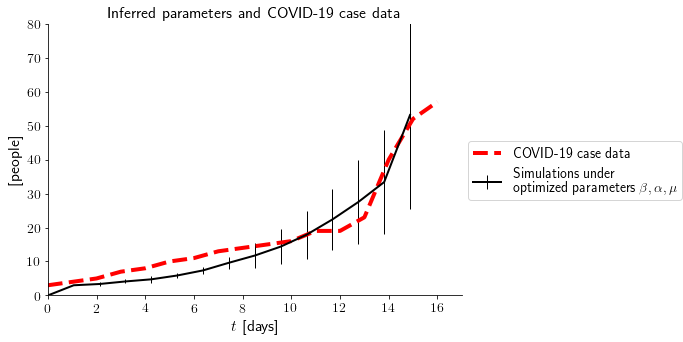

In [35]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary, new_cases.sum(axis=1), 
    test_lag=2,
    title='Inferred parameters and COVID-19 case data', 
    filename='inference_example',
    figsize=(10, 5),
    errorevery=1, acc=17, 
    ymax=80)